
## Assignment 8 - Ryan Timbrook
Assignment Objective:

Perform time series analysis on the data for one of Milk Production, or Ice Cream Production (your choice), in the CADairyProduction.csv file to answer the following questions

   – Q:Is this time series stationary?
       A: No, the Standard Deviation changes each year
   
   – Q:Is there a significant seasonal component?
       A: Yes, the icecream production values show a significant season component
   
   – For the residual from the STL decomposition of the time series what is the order of the ARMA(p,q) process that best fits?

   – Forecast production for 12 months. Report both numeric values and plot the confidence intervals.
       Are the confidence intervals reasonably small compared to the forecast means? 
       How do the confidence intervals behave as time moves to the future?
    
    

In [1]:
# Clear memory and console 
rm(list=ls())
cat('\014')

## FUNCTION - Read CADairyProduction data
read.dairy = function(file = 'CADairyProduction.csv'){
  ## Read the csv file
  dairy.production <- read.csv(file, header = TRUE, stringsAsFactors = FALSE)
  
  ## Remove cases or rows with missing values. 
  dairy.production = dairy.production[complete.cases(dairy.production), ]
  
  ## Icecream Production
  drop.cols = c('Cotagecheese.Prod','Milk.Prod')
  icecream.prod = dairy.production[,!(names(dairy.production) %in% drop.cols)]
  icecream.prod$date = as.Date(paste(icecream.prod$Year,icecream.prod$Month,01, sep='-'),"%Y-%b-%d")
  icecream.prod$Month = as.factor(icecream.prod$Month)
  icecream.prod$lnIcecreamProd = log(icecream.prod$Icecream.Prod)  
  return(icecream.prod)
}

In [40]:
# Get the Dairy Production Data set
icecream.prod = read.dairy()
str(icecream.prod)
head(icecream.prod)
tail(icecream.prod)

'data.frame':	228 obs. of  9 variables:
 $ Year          : int  1995 1995 1995 1995 1995 1995 1995 1995 1995 1995 ...
 $ Month         : Factor w/ 12 levels "Apr","Aug","Dec",..: 5 4 8 1 9 7 6 2 12 11 ...
 $ Icecream.Prod : num  51.6 56.1 68.5 65.7 73.7 ...
 $ N.CA.Fat.Price: num  0.98 0.892 0.892 0.897 0.897 ...
 $ Month.Count   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ monthNumSqred : int  1 4 9 16 25 36 49 64 81 100 ...
 $ monthNumCubed : int  1 8 27 64 125 216 343 512 729 1000 ...
 $ date          : Date, format: "1995-01-01" "1995-02-01" ...
 $ lnIcecreamProd: num  3.94 4.03 4.23 4.19 4.3 ...


Year,Month,Icecream.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed,date,lnIcecreamProd
1995,Jan,51.595,0.9803,1,1,1,1995-01-01,3.943425
1995,Feb,56.086,0.8924,2,4,8,1995-02-01,4.026886
1995,Mar,68.453,0.8924,3,9,27,1995-03-01,4.226147
1995,Apr,65.722,0.8967,4,16,64,1995-04-01,4.185434
1995,May,73.730,0.8967,5,25,125,1995-05-01,4.300410
1995,Jun,77.994,0.9160,6,36,216,1995-06-01,4.356632


,Year,Month,Icecream.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed,date,lnIcecreamProd
223,2013,Jul,84.026,1.6923,223,49729,11089567,2013-07-01,4.431126
224,2013,Aug,78.382,1.6273,224,50176,11239424,2013-08-01,4.361594
225,2013,Sep,74.871,1.5519,225,50625,11390625,2013-09-01,4.315767
226,2013,Oct,70.011,1.5566,226,51076,11543176,2013-10-01,4.248652
227,2013,Nov,61.394,1.7537,227,51529,11697083,2013-11-01,4.117312
228,2013,Dec,53.653,1.6747,228,51984,11852352,2013-12-01,3.982537


Loading required package: repr
Warning message:
"package 'repr' was built under R version 3.3.2"

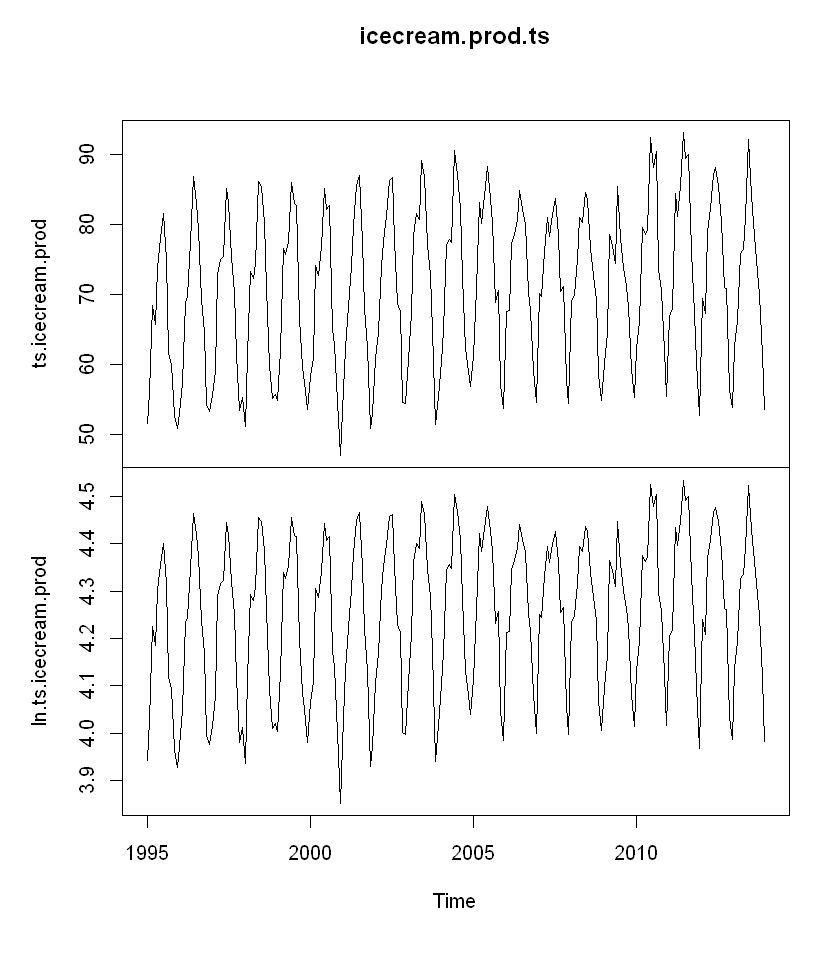

In [3]:
# Require Libraries
if(!require(repr)){install.packages("repr")}

## Create a time series vector for Icecream.Prod
icecream.prod.vec = icecream.prod$Icecream.Prod
icecream.prod.ln.vec = icecream.prod$lnIcecreamProd
ts.icecream.prod = ts(icecream.prod.vec, start = 1995 , freq = 12)
ln.ts.icecream.prod = ts(icecream.prod.ln.vec, start = 1995, freq = 12)
#attributes(ts.icecream.prod)
#attributes(ln.ts.icecream.prod)
icecream.prod.ts = cbind(ts.icecream.prod,ln.ts.icecream.prod)

#plot the time series vector
options(repr.pmales.extlot.width=8, repr.plot.height=8)
plot(icecream.prod.ts) # Note the x-axis is the time attribute

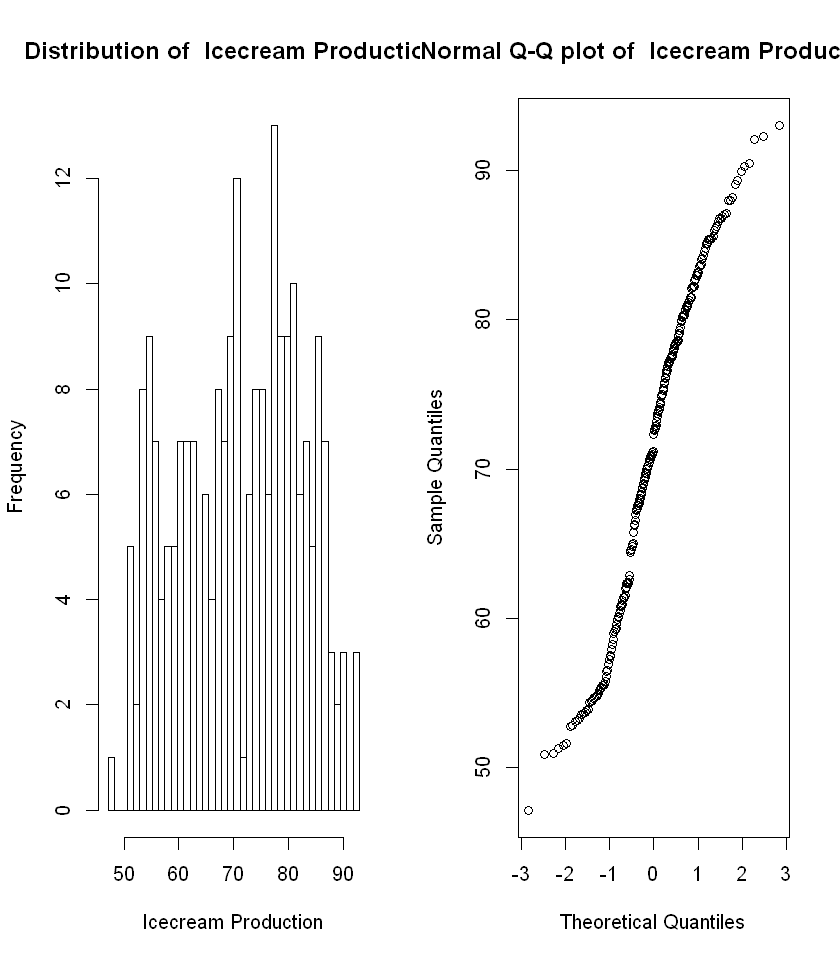

In [4]:
## Distribution of icecream production vector
#icecream.prod.vec
dist.ts = function(df, col = 'residual', bins = 40){
  par(mfrow = c(1,2))
  temp = as.vector(df)
  breaks = seq(min(temp), max(temp), length.out = (bins + 1))
  hist(temp, breaks = breaks, main = paste('Distribution of ', col), xlab = col)
  qqnorm(temp, main = paste('Normal Q-Q plot of ', col))
  par(mfrow = c(1,1))
}
dist.ts(ts.icecream.prod, col = 'Icecream Production')

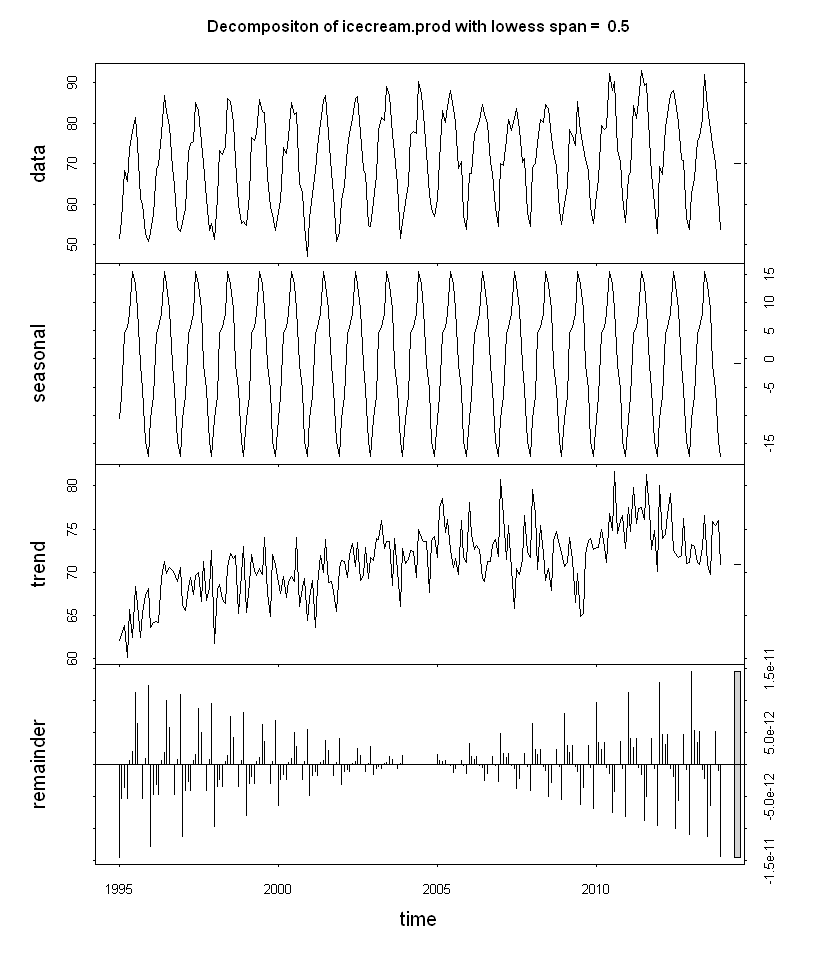

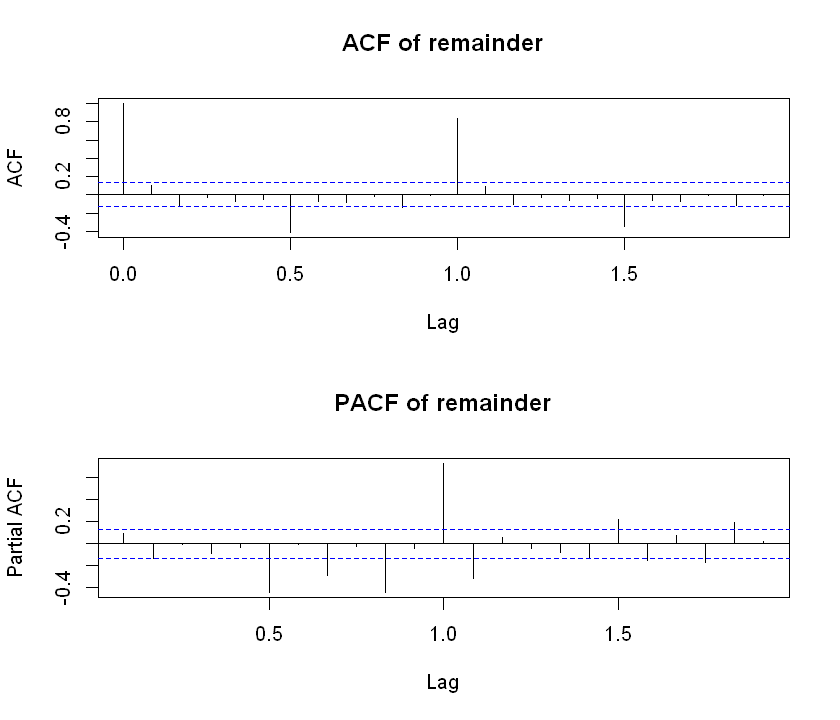

In [7]:
## Decomposition of the time series into components 
fit <- stl(ts.icecream.prod, s.window = "periodic", t.window = 0.5)
plot(fit, main = paste('Decompositon of','icecream.prod','with lowess span = ', as.character(0.5)))
icecream.prod.decomp = fit$time.series

options(repr.pmales.extlot.width=8, repr.plot.height=6)
plot.acf <- function(df, col = 'remainder'){
  par(mfrow = c(2,1))
  acf(df, main = paste('ACF of', col))
  pacf(df, main = paste('PACF of', col))
  par(mfrow = c(1,1))
}

options(repr.pmales.extlot.width=8, repr.plot.height=6)
plot.acf(icecream.prod.decomp[, 3])


For the residual from the STL decomposition of the time series what is the order of the ARMA(p,q) process that best fits?


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
         ar1     ar2      ma1      ma2
      0.1345  0.3177  -0.1327  -0.7510
s.e.  0.0913  0.0877   0.0542   0.0513

sigma^2 estimated as 1.638e-23:  log likelihood = 5657.12,  aic = -11304.24


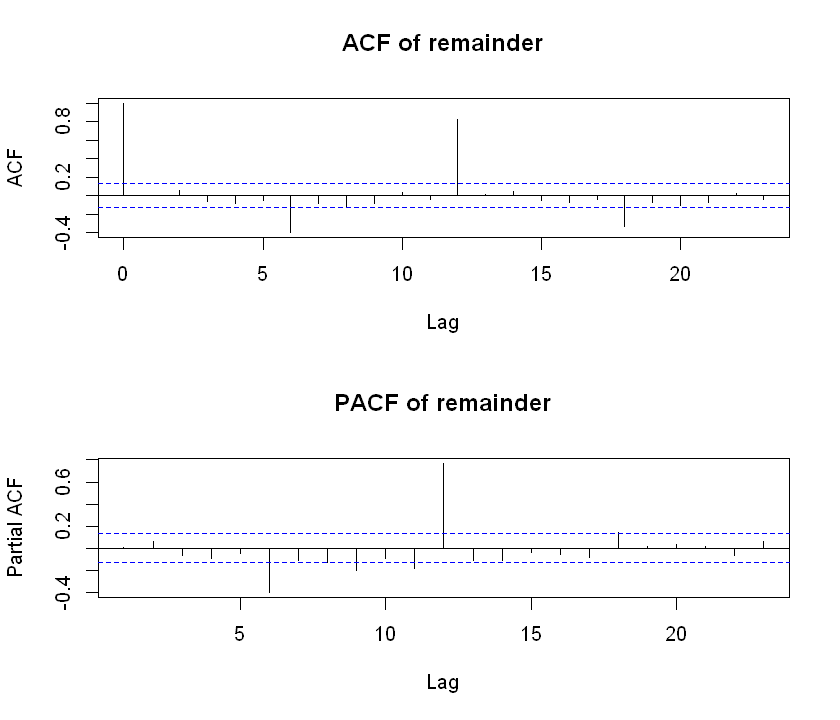

In [41]:
## Function for ARIMA model of icecream production
ts.model = function(ts, col = 'remainder', order = c(0,0,1)){
  mod = arima(ts, order = order, include.mean = FALSE)
  print(mod)
  mod
}
## Compute ARIMA model of icecream production
icecream.prod.arima = ts.model(icecream.prod.decomp[, 3], 
                        col = 'ARIMA model for icecream', order = c(2,0,2))
plot.acf(icecream.prod.arima$resid[-1])

Forecasting Time Series

Forecast production for 12 months. Report both numeric values and plot the confidence intervals. Are the confidence intervals reasonably small compared to the forecast means? How do the confidence intervals behave as time moves to the future?

In [38]:
## Compute Seasonal ARIMA model
if(!require(forecast)){install.packages("forecast")}
fit.icecream.prod = auto.arima(ts.icecream.prod, max.p=3, max.q=3,
                       max.P=2, max.Q=2, max.order=5, max.d=2, max.D=1,
                       start.p=0, start.q=0, start.P=0, start.Q=0)
summary(fit.icecream.prod)

Series: ts.icecream.prod 
ARIMA(3,0,1)(1,1,2)[12] with drift         

Coefficients:
          ar1     ar2     ar3     ma1   sar1     sma1     sma2   drift
      -0.3052  0.2177  0.3482  0.5655  0.026  -0.5470  -0.2335  0.0377
s.e.   0.2020  0.0879  0.0648  0.2203  0.224   0.2184   0.1523  0.0101

sigma^2 estimated as 7.711:  log likelihood=-528.05
AIC=1074.11   AICc=1074.98   BIC=1104.49

Training set error measures:
                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set 0.09698592 2.652346 2.052637 0.0563378 2.892051 0.7436829
                     ACF1
Training set -0.005397972



Forecast method: ARIMA(3,0,1)(1,1,2)[12] with drift

Model Information:
Series: ts.icecream.prod 
ARIMA(3,0,1)(1,1,2)[12] with drift         

Coefficients:
          ar1     ar2     ar3     ma1   sar1     sma1     sma2   drift
      -0.3052  0.2177  0.3482  0.5655  0.026  -0.5470  -0.2335  0.0377
s.e.   0.2020  0.0879  0.0648  0.2203  0.224   0.2184   0.1523  0.0101

sigma^2 estimated as 7.711:  log likelihood=-528.05
AIC=1074.11   AICc=1074.98   BIC=1104.49

Error measures:
                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set 0.09698592 2.652346 2.052637 0.0563378 2.892051 0.7436829
                     ACF1
Training set -0.005397972

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2014       63.62479 60.06560 67.18397 58.18148 69.06809
Feb 2014       68.89726 65.21948 72.57504 63.27258 74.52194
Mar 2014       77.71948 74.00891 81.43005 72.04465 83.39431
Apr 2014       79.58273 75.65412 83.51134 73.57444 85.59103
May 2014    

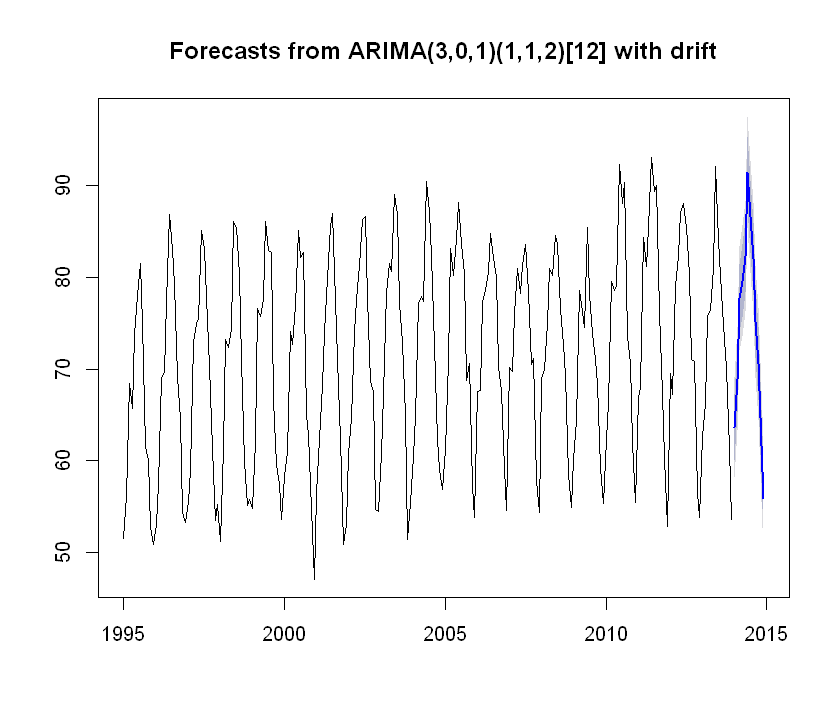

In [39]:
## Make the forecast for the next year
forecast.icecream.prod = forecast(fit.icecream.prod, h=12)
summary(forecast.icecream.prod)
plot(forecast.icecream.prod)